# Определение стоимости автомобилей

В данном проекте нам нужно построить модель для вычисления рыночной стоимости автомобиля. 
Для этого: 
- рассмотрим датасэт, содержащий сведения: техническими характеристиками, комплектацией и ценами автомобилей.

- избавимся от аномалий в данных.

- подготовим данные для обучения.

- обучим данные несколькими моделями.

## Подготовка данных

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from catboost import CatBoostRegressor
from lightgbm.sklearn import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import make_scorer, mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeRegressor
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

Посмотрим, какие данные есть в датасэте.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

- DateCrawled — дата скачивания анкеты из базы
- VehicleType — тип автомобильного кузова
- RegistrationYear — год регистрации автомобиля
- Gearbox — тип коробки передач
- Power — мощность (л. с.)
- Model — модель автомобиля
- Kilometer — пробег (км)
- RegistrationMonth — месяц регистрации автомобиля
- FuelType — тип топлива
- Brand — марка автомобиля
- Repaired — была машина в ремонте или нет
- DateCreated — дата создания анкеты
- NumberOfPictures — количество фотографий автомобиля
- PostalCode — почтовый индекс владельца анкеты (пользователя)
- LastSeen — дата последней активности пользователя
- Price — цена (евро)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7ff801df6f10>,
      dtype=object)

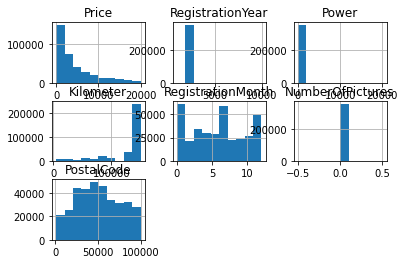

In [ ]:
data.hist()

In [ ]:
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Данные содержат множество пропусков и аномальных значений.

In [ ]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [ ]:
data['DateCrawled'].sort_values()

329497    2016-03-05 14:06:22
220583    2016-03-05 14:06:23
176823    2016-03-05 14:06:24
99885     2016-03-05 14:06:24
324763    2016-03-05 14:06:24
                 ...         
204218    2016-04-07 14:36:53
53739     2016-04-07 14:36:54
301030    2016-04-07 14:36:55
339649    2016-04-07 14:36:56
90713     2016-04-07 14:36:58
Name: DateCrawled, Length: 354369, dtype: object

Удалим столбцы 'DateCrawled', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'RegistrationMonth', 'DateCreated' так как эти данные не влияют на цену автомобиля.

In [ ]:
data = data.drop(['DateCrawled', 'NumberOfPictures', 'PostalCode', 'LastSeen', 'RegistrationMonth', 'DateCreated'], axis=1)

Удалим аномальные значения в мощности, цене и годе регистрации.

In [ ]:
data = data[(data['Power']<400)&
            (data['Power']>=1)&
            (data['RegistrationYear']>1950)&
            (data['RegistrationYear']<2017)&
            (data['Price']>100)]

Посмотрим, что получилось.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294357 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             294357 non-null  int64 
 1   VehicleType       283661 non-null  object
 2   RegistrationYear  294357 non-null  int64 
 3   Gearbox           289139 non-null  object
 4   Power             294357 non-null  int64 
 5   Model             283377 non-null  object
 6   Kilometer         294357 non-null  int64 
 7   FuelType          279180 non-null  object
 8   Brand             294357 non-null  object
 9   Repaired          252128 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.7+ MB


In [ ]:
data.describe()

,Price,RegistrationYear,Power,Kilometer
count,294357.000000,294357.000000,294357.000000,294357.000000
mean,4872.325299,2002.851857,120.324174,128249.285731
std,4599.012421,6.482798,52.507437,36756.668880
min,101.000000,1951.000000,1.000000,5000.000000
25%,1350.000000,1999.000000,76.000000,125000.000000
50%,3200.000000,2003.000000,111.000000,150000.000000
75%,6999.000000,2007.000000,150.000000,150000.000000
max,20000.000000,2016.000000,399.000000,150000.000000


Посчитаем количество пропусков.

In [ ]:
data.isna().sum()

Price                   0
VehicleType         10696
RegistrationYear        0
Gearbox              5218
Power                   0
Model               10980
Kilometer               0
FuelType            15177
Brand                   0
Repaired            42229
dtype: int64

Заполним пропуски в столбце 'Repaired' значением 'no'. Скорее всего пользователи ничего не указывали, если машина не была в ремонте.

In [ ]:
data['Repaired'] = data['Repaired'].fillna('no')

Посмотрим уникальные значения в столбце 'Model'.

In [ ]:
data['Model'].unique()

array([nan, 'grand', 'golf', 'fabia', '3er', '2_reihe', 'c_max',
       '3_reihe', 'passat', 'navara', 'polo', 'twingo', 'a_klasse',
       'scirocco', '5er', 'arosa', 'other', 'civic', 'transporter',
       'punto', 'e_klasse', 'clio', 'kadett', 'one', 'fortwo', '1er',
       'b_klasse', 'a8', 'jetta', 'fiesta', 'c_klasse', 'micra', 'vito',
       'sprinter', 'astra', '156', 'escort', 'forester', 'xc_reihe',
       'scenic', 'ka', 'a1', 'focus', 'a4', 'tt', 'a6', 'jazz', 'omega',
       'slk', '7er', 'combo', 'corsa', '80', '147', 'z_reihe', 'sorento',
       'ibiza', 'mustang', 'eos', 'touran', 'getz', 'insignia', 'almera',
       'megane', 'a3', 'lupo', 'r19', 'caddy', 'mondeo', 'cordoba',
       'colt', 'impreza', 'vectra', 'berlingo', 'tiguan', '6_reihe', 'c4',
       'panda', 'up', 'i_reihe', 'ceed', 'kangoo', '5_reihe', 'yeti',
       'octavia', 'zafira', 'mii', 'rx_reihe', '6er', 'modus', 'fox',
       'matiz', 'beetle', 'rio', 'touareg', 'logan', 'spider', 'cuore',
       's_m

Заполним пропуски значением other.

In [ ]:
data['Model'] = data['Model'].fillna('other')

Проверим оставшиеся пропуски.

In [ ]:
data.isna().sum()

Price                   0
VehicleType         10696
RegistrationYear        0
Gearbox              5218
Power                   0
Model                   0
Kilometer               0
FuelType            15177
Brand                   0
Repaired                0
dtype: int64

Запполним пропуски в столбцах 'VehicleType', 'FuelType' и 'Gearbox' значениями, которые чаще встречаются для данных моделей.

In [ ]:
for t in data['Model'].unique():
    data.loc[(data['Model'] == t) & (data['VehicleType'].isna()), 'VehicleType'] = \
    data.loc[(data['Model'] == t) & (data['VehicleType']), 'VehicleType'].mode()[0]

In [ ]:
for t in data['Model'].unique():
    data.loc[(data['Model'] == t) & (data['Gearbox'].isna()), 'Gearbox'] = \
    data.loc[(data['Model'] == t) & (data['Gearbox']), 'Gearbox'].mode()[0]

In [ ]:
for t in data['Model'].unique():
    data.loc[(data['Model'] == t) & (data['FuelType'].isna()), 'FuelType'] = \
    data.loc[(data['Model'] == t) & (data['FuelType']), 'FuelType'].mode()[0]

In [ ]:
data.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

Пропуски полностью убраны.

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294357 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             294357 non-null  int64 
 1   VehicleType       294357 non-null  object
 2   RegistrationYear  294357 non-null  int64 
 3   Gearbox           294357 non-null  object
 4   Power             294357 non-null  int64 
 5   Model             294357 non-null  object
 6   Kilometer         294357 non-null  int64 
 7   FuelType          294357 non-null  object
 8   Brand             294357 non-null  object
 9   Repaired          294357 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.7+ MB


В данном разделе мы провели предобработку данных:

- удалили аномальные значения.

- заполнили пропуски.

- удалили неинформативные столбцы с датами и количеством фото.

## Обучение моделей

Разделим датасэт на три выборки.

In [ ]:
data_train_valid, data_test = train_test_split(data, test_size=0.2, random_state=42, stratify=data['Model'])
data_train, data_valid = train_test_split(data_train_valid, test_size=0.25, random_state=42, stratify=data_train_valid['Model'])

Выделим целевой признак - 'Price', который будем предсказывать.

In [ ]:
features_test = data_test.drop(['Price'], axis=1)
target_test = data_test['Price']
features_train = data_train.drop(['Price'], axis=1)
target_train = data_train['Price']
features_valid = data_valid.drop(['Price'], axis=1)
target_valid = data_valid['Price']

Закодируем категориальные признаки.

In [ ]:
cat = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'Repaired']
numeric = ['RegistrationYear', 'Kilometer']
encoder = OneHotEncoder(handle_unknown='error', drop='first')
encoder.fit(features_train[cat])
features_train_encoded = pd.DataFrame(
    encoder.transform(features_train[cat]).toarray(),
    columns = encoder.get_feature_names(cat),
    index = features_train.index
)
features_train_ohe = pd.concat((features_train[numeric], features_train_encoded), axis=1)

features_test_encoded = pd.DataFrame(
    encoder.transform(features_test[cat]).toarray(),
    columns = encoder.get_feature_names(cat),
    index = features_test.index
)
features_test_ohe = pd.concat((features_test[numeric], features_test_encoded), axis=1)

features_valid_encoded = pd.DataFrame(
    encoder.transform(features_valid[cat]).toarray(),
    columns = encoder.get_feature_names(cat),
    index = features_valid.index
)
features_valid_ohe = pd.concat((features_valid[numeric], features_valid_encoded), axis=1)

In [ ]:
features_train_lab = features_train.copy()
features_test_lab = features_test.copy()
features_valid_lab = features_valid.copy()

In [ ]:
label_encoder = LabelEncoder()
for i in cat:
    features_train_lab[i] = label_encoder.fit_transform(features_train_lab[i])
    features_valid_lab[i] = label_encoder.transform(features_valid_lab[i])
    features_test_lab[i] = label_encoder.transform(features_test_lab[i])

Посмотрим важность признаков.

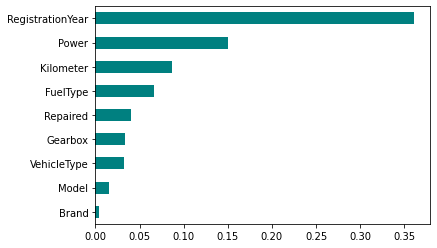

In [ ]:
X = features_train_lab
y = target_train
importances = mutual_info_regression(X=X, y=y)
feature_importances = pd.Series(importances, X.columns)
feature_importances.sort_values().plot(kind='barh', color='teal')
plt.show()

Больше всего на цену влияет год регистрации, мощность и пробег.

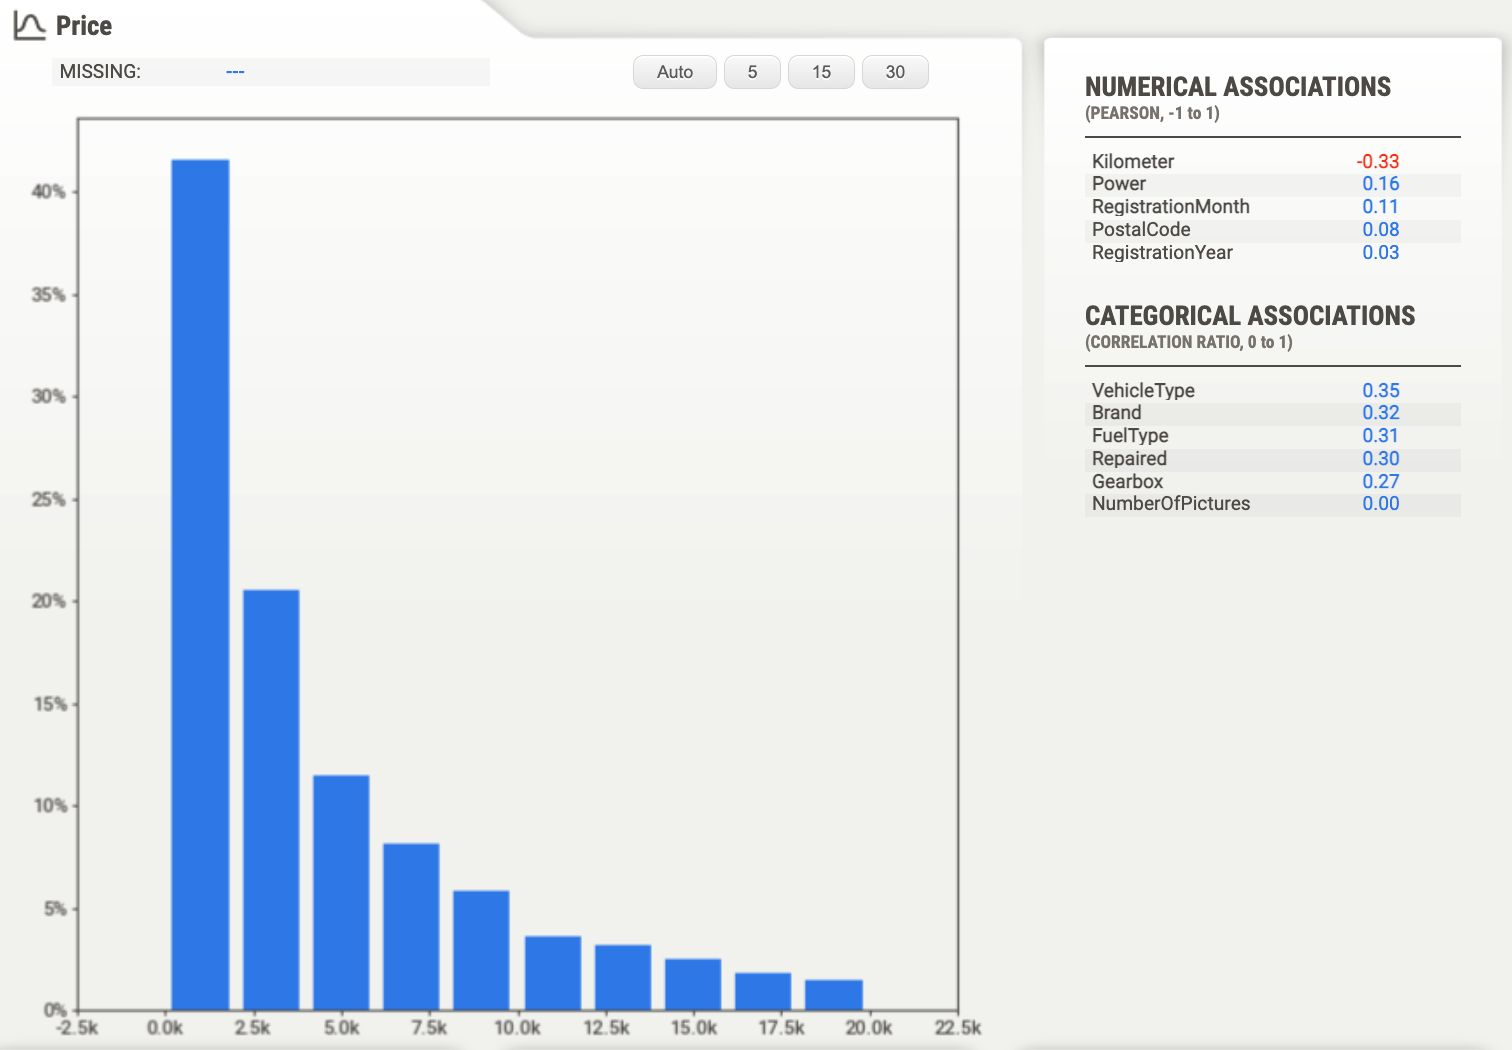

По корреляции Пирсона большее влияние на цену у типа кузова, пробега и брэнда

In [ ]:
mse = make_scorer(mean_squared_error, greater_is_better=False)

Рассмотрим модель - решающее дерево.

In [ ]:
model_dtr = DecisionTreeRegressor(criterion='mse', random_state=189)
parametrs = {'max_depth': [i for i in range(1, 11)],
               }
grid = GridSearchCV(model_dtr, parametrs, cv=5, scoring=mse)
grid.fit(features_train_lab, target_train)
grid.best_params_

{'max_depth': 10}

In [ ]:
model_dtr = model_dtr.set_params(**grid.best_params_)
model_dtr

DecisionTreeRegressor(criterion='mse', max_depth=10, random_state=189)

In [ ]:
%%time
model_dtr.fit(features_train_lab, target_train)

CPU times: user 408 ms, sys: 0 ns, total: 408 ms
Wall time: 406 ms


DecisionTreeRegressor(criterion='mse', max_depth=10, random_state=189)

In [ ]:
%%time
model_dtr.predict(features_valid_lab)

CPU times: user 14.8 ms, sys: 0 ns, total: 14.8 ms
Wall time: 16.6 ms


array([ 1975.70695755, 11598.59264498, 13672.44202899, ...,
        2873.04347826,  1415.66654728,  1415.66654728])

Посмотрим важность признаков для решающего дерева.

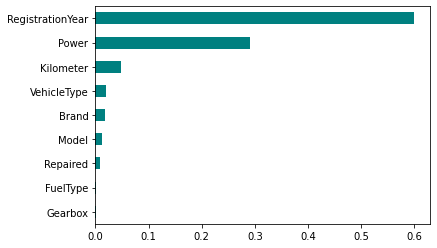

In [ ]:
imp_dtr = model_dtr.feature_importances_
feature_dtr_importances = pd.Series(imp_dtr, X.columns)
feature_dtr_importances.sort_values().plot(kind='barh', color='teal')
plt.show()

Самые важные - это год регистрации и мощность.

Расчитаем RMSE.

In [ ]:
rmse_dtr = (-grid.best_score_)**0.5
rmse_dtr

1966.2593448442165

Рассмотрим модель - ридж.

In [ ]:
%%time
ridge = Ridge(normalize=True, random_state=189)
ridge.fit(features_train_lab, target_train)

CPU times: user 41.4 ms, sys: 41.6 ms, total: 83 ms
Wall time: 117 ms


Ridge(normalize=True, random_state=189)

In [ ]:
%%time
ridge_pred = ridge.predict(features_valid_lab)

CPU times: user 5.11 ms, sys: 6.08 ms, total: 11.2 ms
Wall time: 16.4 ms


Расчитаем RMSE.

In [ ]:
rmse_ridge = mean_squared_error(target_valid, ridge_pred)**(.5)
rmse_ridge

3327.339441548061

Рассмотрим модель - линейную регрессию.

In [ ]:
%%time
linreg = LinearRegression(normalize=True)
linreg.fit(features_train_ohe, target_train)

CPU times: user 8.8 s, sys: 1.49 s, total: 10.3 s
Wall time: 8.7 s


LinearRegression(normalize=True)

In [ ]:
%%time
linreg_pred = linreg.predict(features_valid_ohe)

CPU times: user 68.3 ms, sys: 37.3 ms, total: 106 ms
Wall time: 98.5 ms


Расчитаем RMSE.

In [ ]:
rmse_linreg = mean_squared_error(target_valid, linreg_pred)**(.5)
rmse_linreg

2862.03492002828

Рассмотрим модель лассо.

In [ ]:
%%time
lasso = Lasso(normalize=True, random_state=189)
lasso.fit(features_train_lab, target_train)

CPU times: user 71.9 ms, sys: 9.09 ms, total: 81 ms
Wall time: 60 ms


Lasso(normalize=True, random_state=189)

In [ ]:
%%time
lasso_pred = lasso.predict(features_valid_lab)

CPU times: user 6.35 ms, sys: 1.92 ms, total: 8.27 ms
Wall time: 7.85 ms


Расчитаем RMSE.

In [ ]:
rmse_lasso = mean_squared_error(target_valid, lasso_pred)**(.5)
rmse_lasso

3089.479221803026

Применим модель LightGBM.

In [ ]:
%%time
model_lgb = LGBMRegressor()
model_lgb.fit(features_train_lab, target_train)

CPU times: user 5.48 s, sys: 38.2 ms, total: 5.52 s
Wall time: 4.27 s


LGBMRegressor()

In [ ]:
%%time
lgb_pred = model_lgb.predict(features_valid_lab)

CPU times: user 510 ms, sys: 2.56 ms, total: 512 ms
Wall time: 274 ms


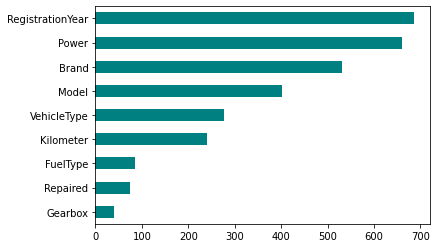

In [ ]:
imp_lgb = model_lgb.feature_importances_
feature_lgb_importances = pd.Series(imp_lgb, X.columns)
feature_lgb_importances.sort_values().plot(kind='barh', color='teal')
plt.show()

Для модели LightGBM самые важные признаки - год регистрации мощность и бренд.

In [ ]:
rmse_lgb = mean_squared_error(target_valid, lgb_pred)**(.5)
rmse_lgb

1693.6685261017797

In [ ]:
%%time
cat = CatBoostRegressor(loss_function='RMSE')
cat.fit(features_train_lab, target_train, verbose=False)

CPU times: user 45.3 s, sys: 2.78 s, total: 48.1 s
Wall time: 29.5 s


In [ ]:
%%time
preds = cat.predict(features_valid_lab)

CPU times: user 113 ms, sys: 3.84 ms, total: 117 ms
Wall time: 105 ms


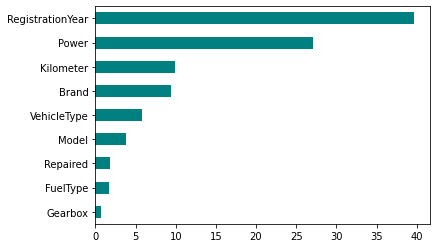

In [ ]:
imp_cat = cat.feature_importances_
feature_cat_importances = pd.Series(imp_cat, X.columns)
feature_cat_importances.sort_values().plot(kind='barh', color='teal')
plt.show()

Для модели Catboost самыми важными признаками являются год регистрации и пробег.

In [ ]:
rmse_cat = mean_squared_error(target_valid, preds)**(.5)
rmse_cat

1601.5399237825698

Рассмотрим модель - "Случайный лес".

In [ ]:
clf = RandomForestRegressor(random_state=189)
n_estimators = range(10, 80, 10)
max_depth = range(1, 7)
param_dist = {'n_estimators': n_estimators,
              'max_depth': max_depth,
}
gs = GridSearchCV(clf, param_dist, cv = 3, verbose = 1, n_jobs=-1, scoring=mse)
gs.fit(features_train_lab, target_train)
gs.best_params_

Fitting 3 folds for each of 42 candidates, totalling 126 fits


{'max_depth': 6, 'n_estimators': 70}

In [ ]:
model_rfr = clf.set_params(**gs.best_params_)
model_rfr

RandomForestRegressor(max_depth=6, n_estimators=70, random_state=189)

In [ ]:
# %%time
# model_rfr.fit(features_train_lab, target_train)

CPU times: user 15 s, sys: 16.5 ms, total: 15 s
Wall time: 15.1 s


RandomForestRegressor(max_depth=6, n_estimators=70, random_state=189)

In [ ]:
%%time
model_rfr.predict(features_valid_lab)

CPU times: user 278 ms, sys: 848 µs, total: 279 ms
Wall time: 279 ms


array([ 1900.70967585, 10850.89206036, 12671.12380546, ...,
        1907.86300677,  1552.73900525,  1552.73900525])

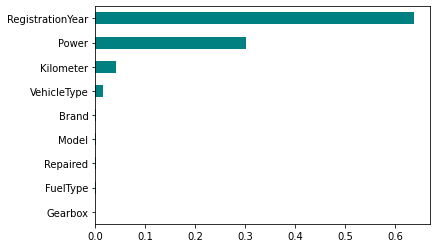

In [ ]:
imp_rfr = model_rfr.feature_importances_
feature_rfr_importances = pd.Series(imp_rfr, X.columns)
feature_rfr_importances.sort_values().plot(kind='barh', color='teal')
plt.show()

Для случайного леса важные параметры - год регистрации и мощность автомобиля.

In [ ]:
rmse_forest = (-gs.best_score_)**0.5
rmse_forest

2209.0929120442684

В данном разделе мы рассмотрели несколько моделей:

- DecisionTree

- Ridge

- Lasso

- RandomForestRegression

- LinearRegression

Модели бустинга:

- LightGBM

- CatBoostRegressor

Расчитали метрики RMSE и время выполнения моделей. Для каждой модели различается важность признаков. В основном это дата регистрации автомобиля и пробег.

## Анализ моделей

Проанализируем модели и найдем лучшую по метрике и времени выполнения. По условию RMSE должно быть меньше 2500.

In [ ]:
col = {
    'Model': ['DecisionTree', 'Ridge', 'Lasso', 'RandomForestRegression', 'LinearRegression', 'LightGBM', 'CatBoostRegressor'],
    'RMSE': [rmse_dtr, rmse_ridge, rmse_lasso, 2209, rmse_linreg, rmse_lgb, rmse_cat],
    'Fit Time': ['873 ms', '296 ms', '54,9 ms', '15,1 s', '8.7 ms', '1,6 s', '31,4 s'],
    'Predict Time': ['20,7 ms', '7,65 ms', '13 ms', '279 ms', '98.5 ms', '294 ms', '73,5 ms'],
}
final_scoring = pd.DataFrame(data=col)
final_scoring

,Model,RMSE,Fit Time,Predict Time
0,DecisionTree,1966.259345,873 ms,"20,7 ms"
1,Ridge,3327.339442,296 ms,"7,65 ms"
2,Lasso,3089.479222,"54,9 ms",13 ms
3,RandomForestRegression,2209.000000,"15,1 s",279 ms
4,LinearRegression,2862.034920,8.7 ms,98.5 ms
5,LightGBM,1693.668526,"1,6 s",294 ms
6,CatBoostRegressor,1601.539924,"31,4 s","73,5 ms"


Дольше всего выполняется модель CatBoost. Быстрее всего - Лассо. Лучшие метрики у моделей бустинга. У модели LightGBM лучшее быстродействие 1.6s. Но RMSE лучше у CatBoost = 1601.


Проверим модели на тестовой выборке.

In [ ]:
%%time
pred_test = cat.predict(features_test_lab)
rmse_test = mean_squared_error(target_test, pred_test)**(.5)
rmse_test

CPU times: user 142 ms, sys: 0 ns, total: 142 ms
Wall time: 125 ms


1574.155590565021

На тестовой выборке модель выдала хороший результат RMSE=1574.

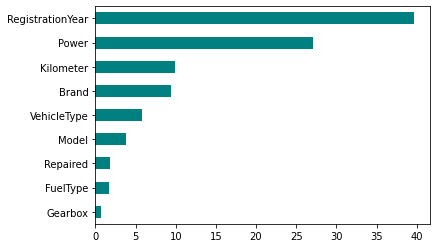

In [ ]:
imp_cat_test = cat.feature_importances_
feature_cat_test_importances = pd.Series(imp_cat_test, features_test_lab.columns)
feature_cat_test_importances.sort_values().plot(kind='barh', color='teal')
plt.show()

## Выводы.

Мы проанализировали датасэт с данными об автомобилях. Целью задачи было построение модели предсказания цены автомобиля.

На этапе предобработки данных:

- удалили аномальные значения.

- заполнили пропуски.

- удалили неинформативные столбцы с датами и количеством фото.

На этапе обучения моделей рассмотрели:

- DecisionTree

- Ridge

- Lasso

- RandomForestRegression

- LinearRegression

Модели бустинга:

- LightGBM

- CatBoostRegressor

Расчитали метрики RMSE и время выполнения моделей. Узнали важность признаков для каждой модели.

Лучший результат показала модель CatBoostRegressor RMSE=1574. Проверка на тестовой выборке подтвердила результат. 

Самые важные признаки для этой модели:

- год регистрации

- мощность

- пробег

- бренд